Akshay: elastic net, SVM
  
Jørgen: LDA, random forests (decision trees)

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("telco_train.csv", index_col=0)
df_test = pd.read_csv("telco_test.csv", index_col=0)

### Feature Selection and Engineering

In [4]:
df.head(10)

,gender,senior,partner,dependents,tenure,phone,multiple_lines,online_security,online_backup,device_protection,...,monthly_charges,total_charges,internet_dsl,internet_fiber,contract_1_yr,contract_2_yr,payment_credit_card,payment_electronic_check,payment_mailed_check,churn
2142,0,0,0,1,21,1,0,1,0,1,...,64.85,1336.80,1,0,1,0,0,0,1,0
1623,0,0,0,0,54,1,1,0,1,0,...,97.20,5129.45,0,1,0,1,0,0,0,0
6074,1,0,1,0,1,0,0,0,0,0,...,23.45,23.45,1,0,0,0,0,1,0,1
1362,1,0,0,0,4,1,0,0,0,0,...,70.20,237.95,0,1,0,0,0,1,0,1
6754,1,0,0,1,0,1,1,1,1,0,...,61.90,0.00,1,0,0,1,0,0,0,0
1212,1,0,0,0,7,1,0,0,0,0,...,69.55,521.35,0,1,0,0,0,1,0,0
2722,1,0,1,1,32,1,0,0,0,0,...,18.95,613.95,0,0,0,1,0,0,1,0
4006,1,0,1,1,72,1,0,0,0,0,...,19.80,1414.65,0,0,0,1,1,0,0,0
6791,1,0,0,0,19,0,0,0,0,1,...,39.65,733.35,1,0,0,0,0,1,0,1
5466,1,0,0,1,10,1,0,0,0,0,...,19.95,219.50,0,0,1,0,0,0,0,0


In [5]:
# Adding feature for average charges by tenure

df["average_charges"] = df.apply(lambda x: 0.0 if int(x["tenure"])==0 else x["total_charges"]/float(x["tenure"]), axis=1)
df_test["average_charges"] = df_test.apply(lambda x: 0.0 if int(x["tenure"])==0 else x["total_charges"]/float(x["tenure"]), axis=1)

df["single_parent"] = df.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])!=0) else 0, axis=1)
df_test["single_parent"] = df_test.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])!=0) else 0, axis=1)

df["lonely_senior"] = df.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])==0 and int(x['senior'])==1) else 0, axis=1)
df_test["lonely_senior"] = df_test.apply(lambda x: 1 if (int(x['partner'])==0 and int(x['dependents'])==0 and int(x['senior'])==1) else 0, axis=1)

df["repeat_renewer"] = df.apply(lambda x: 1 if (int(x['tenure'])>12 and int(x['contract_1_yr'])==0 and int(x['contract_2_yr'])==0) else 0, axis=1)
df_test["repeat_renewer"] = df_test.apply(lambda x: 1 if (int(x['tenure'])>12 and int(x['contract_1_yr'])==0 and int(x['contract_2_yr'])==0) else 0, axis=1)

print(np.sum(df["repeat_renewer"]))

1502


In [6]:
X = df.drop(["churn"], axis=1)
#y = pd.reset_index(df.churn)
y = df.churn.reset_index().churn

X_test = df_test.drop(["churn"], axis=1)
y_test = df_test.churn.reset_index().churn

In [7]:
X = X.astype(np.float64)
X_test = X_test.astype(np.float64)
Xu = X.values
Xu_test = X_test.values

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.fit_transform(X_test)

In [9]:
#Split for Cross Validation

from sklearn.model_selection import KFold

kf = KFold(n_splits=10)
kf.get_n_splits(X)
print(kf)

KFold(n_splits=10, random_state=None, shuffle=False)


In [10]:
from sklearn.metrics import f1_score, roc_auc_score, log_loss 

In [11]:
from sklearn.feature_selection import RFE

Prior to Running models, we can set a baseline by calculating the null accuracy

In [12]:
1-np.mean(y)

0.7344692935747249

### Logistic Regression Models

In [13]:
# Simple Logistic Regression

from sklearn.linear_model import LogisticRegression 

logreg_basic = LogisticRegression(solver="lbfgs", random_state=0)
logreg_basic.fit(X, y)
print("Accuracy of Logistic Regression on training set: {:.2f}".format(logreg_basic.score(X, y)))
print("Accuracy of Logistic Regression on test set: {:.2f}".format(logreg_basic.score(X_test, y_test)))

# Generalized Error

gen_error_lrb = list()
f1_lrb = list()
ra_lrb = list()
ll_lrb = list()

for train_index, test_index in kf.split(X):
    logreg_basic_gen = LogisticRegression(solver="lbfgs", random_state=0)
    logreg_basic_gen.fit(X[train_index], y[train_index])
    gen_error_lrb.append(logreg_basic_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_basic_gen.predict(X[test_index])
    f1_lrb.append(f1_score(y[test_index],y_pred))
    ra_lrb.append(roc_auc_score(y[test_index],y_pred))
    ll_lrb.append(log_loss(y[test_index],y_pred))
    
print(np.mean(gen_error_lrb))
print(np.mean(f1_lrb))
print(np.mean(ra_lrb))
#print(np.mean(ll_lrb))
#print(log_loss(y,logreg_basic.predict(X)))

Accuracy of Logistic Regression on training set: 0.80
Accuracy of Logistic Regression on test set: 0.81
0.7994290339241401
0.5712763973228642
0.7059542035844095


In [14]:
# Testing RFE

selector = RFE(logreg_basic, step=1)
selector.fit(X,y)

selector.score(X,y)

0.8022719204827831

In [15]:
## https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d

from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [17]:
# lr1 = LogisticReg(solver="lbfgs", random_state=0)
# lr1.fit(X,y)
# z = lr1.z_scores
# p = lr1.p_values
# zipped = list(zip(list(features), z, p))
# lr1_summary = pd.DataFrame(zipped)
# lr1_summary

In [18]:
# Ridge Logistic Regression

from sklearn.linear_model import LogisticRegression 

logreg_ridge = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2")
logreg_ridge.fit(X, y)
print("Accuracy of Ridge Logistic Regression on training set: {:.2f}".format(logreg_ridge.score(X, y)))
print("Accuracy of Ridge Logistic Regression on test set: {:.2f}".format(logreg_ridge.score(X_test, y_test)))


# Estimating Ridge Parameter

best_c = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c=c

print(best_c)

# Generalized Error

gen_error_lrr = list()
f1_lrr = list()
ra_lrr = list()

for train_index, test_index in kf.split(X):
    logreg_ridge_gen = LogisticRegression(solver="lbfgs", random_state=0, penalty="l2", C=best_c)
    logreg_ridge_gen.fit(X[train_index], y[train_index])
    gen_error_lrr.append(logreg_ridge_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_ridge_gen.predict(X[test_index])
    f1_lrr.append(f1_score(y[test_index],y_pred))
    ra_lrr.append(roc_auc_score(y[test_index],y_pred))

print(np.mean(gen_error_lrr))
print(np.mean(f1_lrr))
print(np.mean(ra_lrr))

Accuracy of Ridge Logistic Regression on training set: 0.80
Accuracy of Ridge Logistic Regression on test set: 0.81
0.08
0.8012030283561972
0.5732844092701364
0.7070690956857325


In [19]:
# Lasso Logistic Regression

from sklearn.linear_model import LogisticRegression 

logreg_lasso = LogisticRegression(solver='saga', random_state=0, penalty="l1")
logreg_lasso.fit(X, y)
print("Accuracy of Lasso Logistic Regression on training set: {:.2f}".format(logreg_lasso.score(X, y)))
print("Accuracy of Lasso Logistic Regression on test set: {:.2f}".format(logreg_lasso.score(X_test, y_test)))

# Estimating Lasso Parameter

best_c = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = LogisticRegression(solver="saga", random_state=0, penalty="l1", C=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c=c

print(best_c)

# Generalized Error

gen_error_lrl = list()
f1_lrl = list()
ra_lrl = list()

for train_index, test_index in kf.split(X):
    logreg_lasso_gen = LogisticRegression(solver="saga", random_state=0, penalty="l2", C=best_c)
    logreg_lasso_gen.fit(X[train_index], y[train_index])
    gen_error_lrl.append(logreg_lasso_gen.score(X[test_index], y[test_index]))
    y_pred = logreg_lasso_gen.predict(X[test_index])
    f1_lrl.append(f1_score(y[test_index],y_pred))
    ra_lrl.append(roc_auc_score(y[test_index],y_pred))
    
print(np.mean(gen_error_lrl))
print(np.mean(f1_lrl))
print(np.mean(ra_lrl))

Accuracy of Lasso Logistic Regression on training set: 0.80
Accuracy of Lasso Logistic Regression on test set: 0.81


C:\Users\jlund\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jlund\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jlund\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jlund\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\jlund\AppData\Local\Continuum\anaconda3\lib\sit

0.07
0.8010254084627692
0.5723260400530068
0.7065065819075745


### Discriminant analysis
Assumes multivariate Gaussian distributions, while we have a majority of binary variables. Skip.

#### LDA  

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
print("Accuracy of LDA on training set: {:.2f}".format(lda.score(X, y)))
print("Accuracy of LDA on test set: {:.2f}".format(lda.score(X_test, y_test)))

# Generalized Error

gen_error_lda = list()
f1_lda = list()
ra_lda = list()


for train_index, test_index in kf.split(X):
    lda_gen = LinearDiscriminantAnalysis()
    lda_gen.fit(X[train_index], y[train_index])
    gen_error_lda.append(lda_gen.score(X[test_index], y[test_index]))
    y_pred = lda_gen.predict(X[test_index])
    f1_lda.append(f1_score(y[test_index],y_pred))
    ra_lda.append(roc_auc_score(y[test_index],y_pred))

print("Generalized Error on LDA: ",np.mean(gen_error_lda))
print("F1 score on LDA: ",np.mean(f1_lda))
print("ROC-AUC Score on LDA: ",np.mean(ra_lda))

Accuracy of LDA on training set: 0.80
Accuracy of LDA on test set: 0.81
Generalized Error on LDA:  0.7988958593149669
F1 score on LDA:  0.5710837633952383
ROC-AUC Score on LDA:  0.7060737173292818


#### QDA

In [21]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

qda = QuadraticDiscriminantAnalysis()
qda.fit(X, y)
print("Accuracy of QDA on traning set: {:.2f}".format(qda.score(X, y)))
print("Accuracy of QDA on test set: {:.2f}".format(qda.score(X_test, y_test)))

# Generalized Error

gen_error_qda = list()
f1_qda = list()
ra_qda = list()

for train_index, test_index in kf.split(X):
    qda_gen = QuadraticDiscriminantAnalysis()
    qda_gen.fit(X[train_index], y[train_index])
    gen_error_qda.append(qda_gen.score(X[test_index], y[test_index]))
    y_pred = qda_gen.predict(X[test_index])
    f1_qda.append(f1_score(y[test_index],y_pred))
    ra_qda.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on QDA: ",np.mean(gen_error_qda))
print("F1 Score on QDA: ",np.mean(f1_qda))
print("ROC-AUC Score on QDA: ",np.mean(ra_qda))

Accuracy of QDA on traning set: 0.76
Accuracy of QDA on test set: 0.76
Generalized Error on QDA:  0.7511510650895028
F1 Score on QDA:  0.6162503370118168
ROC-AUC Score on QDA:  0.7527692176254981


In [121]:
# Estimating QDA regularization Parameter

best_c = 0
best_score = 0

for i in range(1,101):
    c = (i/100)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = QuadraticDiscriminantAnalysis(reg_param=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_c=c

print(best_c)

# Generalized Error

gen_error_qda = list()
f1_qda = list()
ra_qda = list()

for train_index, test_index in kf.split(X):
    qda_gen = QuadraticDiscriminantAnalysis(reg_param=best_c)
    qda_gen.fit(X[train_index], y[train_index])
    gen_error_qda.append(qda_gen.score(X[test_index], y[test_index]))
    y_pred = qda_gen.predict(X[test_index])
    f1_qda.append(f1_score(y[test_index],y_pred))
    ra_qda.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on QDA: ",np.mean(gen_error_qda))
print("F1 Score on QDA: ",np.mean(f1_qda))
print("ROC-AUC Score on QDA: ",np.mean(ra_qda))

0.76
Generalized Error on QDA:  0.7763504150762757
F1 Score on QDA:  0.6096569994237091
ROC-AUC Score on QDA:  0.739448361846373


## Decision Tree

In [94]:
from sklearn import tree

dtc = tree.DecisionTreeClassifier().fit(X, y)

print("Accuracy of Decision Tree classifier on training set: {:.2f}".format(dtc.score(X, y)))
print("Accuracy of Decision Tree classifier on test set: {:.2f}".format(dtc.score(X_test, y_test)))

# Generalized Error
gen_error_dt = list()

for train_index, test_index in kf.split(X):
    dt_gen = tree.DecisionTreeClassifier()
    dt_gen.fit(X[train_index], y[train_index])
    gen_error_dt.append(dt_gen.score(X[test_index], y[test_index]))
    
print("Generalized Error on Decision Tree: ",np.mean(gen_error_dt))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.71
Generalized Error on Decision Tree:  0.7216844286560095


In [ ]:
# import graphviz
# viz = tree.export_graphviz(dtc, out_file=None, 
#                            feature_names=cols)
# graph = graphviz.Source(viz)
# graph.render("viz3")

## K-Nearest Neighbors

In [95]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier().fit(X, y)

print("Accuracy of KNN classifier on training set: {:.2f}".format(knn.score(X, y)))
print("Accuracy of KNN classifier on test set: {:.2f}".format(knn.score(X_test, y_test)))


# Generalized Error
gen_error_knn = list()
f1_knn = list()
ra_knn = list()


for train_index, test_index in kf.split(X):
    knn_gen = KNeighborsClassifier()
    knn_gen.fit(X[train_index], y[train_index])
    gen_error_knn.append(knn_gen.score(X[test_index], y[test_index]))
    y_pred = knn_gen.predict(X[test_index])
    f1_knn.append(f1_score(y[test_index],y_pred))
    ra_knn.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on K Nearest Neighbour: ",np.mean(gen_error_knn))
print("F1 Score on K Nearest Neighbour: ",np.mean(f1_knn))
print("ROC-AUC Score on K Nearest Neighbour: ",np.mean(ra_knn))


Accuracy of KNN classifier on training set: 0.83
Accuracy of KNN classifier on test set: 0.77
Generalized Error on K Nearest Neighbour:  0.7532802993084162
F1 Score on K Nearest Neighbour:  0.5183696406433148
ROC-AUC Score on K Nearest Neighbour:  0.673015287041028


## Gaussian Naive Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB().fit(X, y)

print("Accuracy of GNB classifier on training set: {:.2f}".format(gnb.score(X, y)))
print("Accuracy of GNB classifier on test set: {:.2f}".format(gnb.score(X_test, y_test)))


# Generalized Error

gen_error_gnb = list()
f1_gnb = list()
ra_gnb = list()

for train_index, test_index in kf.split(X):
    gnb_gen = GaussianNB()
    gnb_gen.fit(X[train_index], y[train_index])
    gen_error_gnb.append(gnb_gen.score(X[test_index], y[test_index]))
    y_pred = gnb_gen.predict(X[test_index])
    f1_gnb.append(f1_score(y[test_index],y_pred))
    ra_gnb.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on Gaussian Naive Bayes: ",np.mean(gen_error_gnb))
print("F1 Score on Gaussian Naive Bayes: ",np.mean(f1_gnb))
print("ROC-AUC Score on Gaussian Naive Bayes: ",np.mean(ra_gnb))


Accuracy of GNB classifier on training set: 0.76
Accuracy of GNB classifier on test set: 0.78
Generalized Error on Gaussian Naive Bayes:  0.7547015733847297
F1 Score on Gaussian Naive Bayes:  0.6008011378571447
ROC-AUC Score on Gaussian Naive Bayes:  0.7367622219679558


## Support Vector Machine

In [97]:
from sklearn.svm import SVC 

svm = SVC().fit(X, y)

print("Accuracy of SVM classifier on training set: {:.2f}".format(svm.score(X, y)))
print("Accuracy of SVM classifier on test set: {:.2f}".format(svm.score(X_test, y_test)))


# Generalized Error

gen_error_svm = list()
f1_svm = list()
ra_svm = list()


for train_index, test_index in kf.split(X):
    svm_gen = SVC()
    svm_gen.fit(X[train_index], y[train_index])
    gen_error_svm.append(svm_gen.score(X[test_index], y[test_index]))
    y_pred = svm_gen.predict(X[test_index])
    f1_svm.append(f1_score(y[test_index],y_pred))
    ra_svm.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on Support Vector Machine: ",np.mean(gen_error_svm))
print("F1 Score on Support Vector Machine: ",np.mean(f1_svm))
print("ROC-AUC Score on Support Vector Machine: ",np.mean(ra_svm))

Accuracy of SVM classifier on training set: 0.82
Accuracy of SVM classifier on test set: 0.81
Generalized Error on Support Vector Machine:  0.7930394416940654
F1 Score on Support Vector Machine:  0.5481000836959161
ROC-AUC Score on Support Vector Machine:  0.6912129842434613


## RBF SVM

In [ ]:
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.gaussian_process.kernels import RBF

# rbf = GaussianProcessClassifier(1.0 * RBF(1.0))
# rbf.fit(X, y)

# print("Accuracy of RBF SVM classifier on training set: {:.2f}".format(rbf.score(X, y)))
# print("Accuracy of RBF SVM classifier on test set: {:.2f}".format(rbf.score(X_test, y_test)))

## Random Forests

In [98]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()
rfc.fit(X, y)

print("Accuracy of Random Forests classifier on training set: {:.2f}".format(rfc.score(X, y)))
print("Accuracy of Random Forests classifier on test set: {:.2f}".format(rfc.score(X_test, y_test)))

# Generalized Error
gen_error_rf = list()
f1_rf = list()
ra_rf = list()


for train_index, test_index in kf.split(X):
    rf_gen = RandomForestClassifier()
    rf_gen.fit(X[train_index], y[train_index])
    gen_error_rf.append(rf_gen.score(X[test_index], y[test_index]))
    y_pred = svm_gen.predict(X[test_index])
    f1_rf.append(f1_score(y[test_index],y_pred))
    ra_rf.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on Random Forests: ",np.mean(gen_error_rf))
print("F1 Score on Random Forests: ",np.mean(f1_rf))
print("ROC AUC Score on Random Forests: ",np.mean(ra_rf))

Accuracy of Random Forests classifier on training set: 0.98
Accuracy of Random Forests classifier on test set: 0.79
Generalized Error on Random Forests:  0.7790143985488077
F1 Score on Random Forests:  0.6088578200873603
ROC AUC Score on Random Forests:  0.7278069098782856


In [45]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameters 
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 100)] # Number of trees in forest
max_features = ['auto'] # Number of features considered at each split
max_depth = [int(x) for x in np.linspace(1, 110, num = 100)] # Max levels in the tree
min_samples_split = [2, 5, 10] # Min number of samples required to split a node, 
min_samples_leaf = [1, 2, 3] # Min number of samples required at each leaf node
bootstrap = [True, False] # Bootstrapped sample selection

random_grid = {'n_estimators':n_estimators, 
               'max_features':max_features,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split,
               'min_samples_leaf':min_samples_leaf,
               'bootstrap':bootstrap}

In [46]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 50, cv = 3, verbose = 2, random_state = 42,
                               n_jobs = -1)

rf_random.fit(X, y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 211, 231, 251, 271, 291, 311, 331, 351, 371, 391, 412, 432, 452, 472, 492, 512, 532, 552, 572, 592, 613, 633, 653, 673, 693, 713, 733, 753, 773, 793, 814, 834, 854, 874, 894, 914, 934, 954, 974, 994, 1015, 1035, 1055,...8, 110], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3], 'bootstrap': [True, False]},
          pre_dis

In [50]:
rf_random.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=67, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1738, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [51]:
# Generalized Error
gen_error_rf = list()

for train_index, test_index in kf.split(X):
    rf_best = rf_random.best_estimator_
    rf_best.fit(X[train_index], y[train_index])
    gen_error_rf.append(rf_best.score(X[test_index], y[test_index]))
    
print("Generalized Error on Random Forests: ",np.mean(gen_error_rf))

Generalized Error on Random Forests:  0.8006679641736897


In [ ]:
from sklearn.model_selection import GridSearchCV

In [61]:
rf_best.score(X_test, y_test)

0.8062455642299503

In [62]:
from sklearn.metrics import roc_curve, auc

rf_y_pred = rf_best.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, rf_y_pred)
roc_auc = auc(fpr, tpr)
roc_auc

0.6949561108408294

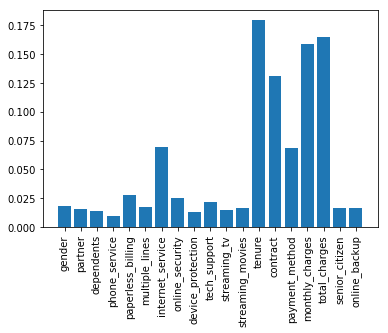

In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = list(rf_best.feature_importances_)
x_values = list(range(len(importances)))
plt.bar(x_values, importances)
features_list = df.columns.values[1:-1]
plt.xticks(x_values, features_list, rotation = 'vertical')
plt.show()

## AdaBoost

In [12]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X, y)

print("Accuracy of AdaBoost classifier on training set: {:.2f}".format(ada.score(X, y)))
print("Accuracy of AdaBoost classifier on test set: {:.2f}".format(ada.score(X_test, y_test)))
####

# Generalized Error

gen_error_ab = list()

for train_index, test_index in kf.split(X):
    ab_gen = AdaBoostClassifier()
    ab_gen.fit(X[train_index], y[train_index])
    gen_error_ab.append(ab_gen.score(X[test_index], y[test_index]))
    
print("Generalized Error on AdaBoost: ",np.mean(gen_error_ab))

Accuracy of AdaBoost classifier on training set: 0.80
Accuracy of AdaBoost classifier on test set: 0.81
Generalized Error on AdaBoost:  0.7964094957358628


## Neural Net

In [99]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(alpha=1)
mlp.fit(X, y)

print("Accuracy of MLP classifier on training set: {:.2f}".format(mlp.score(X, y)))
print("Accuracy of MLP classifier on test set: {:.2f}".format(mlp.score(X_test, y_test)))


# Generalized Error

gen_error_nn = list()

for train_index, test_index in kf.split(X):
    nn_gen = MLPClassifier(alpha=1)
    nn_gen.fit(X[train_index], y[train_index])
    gen_error_nn.append(nn_gen.score(X[test_index], y[test_index]))
    
print("Generalized Error on NN: ",np.mean(gen_error_nn))

Accuracy of MLP classifier on training set: 0.81
Accuracy of MLP classifier on test set: 0.82
Generalized Error on NN:  0.7972994847763374


### Tuning Hyperparameter of Neural Net to Maximise Generalized Score

In [100]:
# Estimating Hyper-Parameter

best_alpha = 0
best_score = 0

for i in range(1,6):
    c = (i/5)
    score_list = list()
    
    for train_index, test_index in kf.split(X):
        temp_model = MLPClassifier(alpha=c)
        temp_model.fit(X[train_index], y[train_index])
        score_list.append(temp_model.score(X[test_index], y[test_index]))
    
    if np.mean(score_list)>best_score:
        best_score=np.mean(score_list)
        best_alpha=c

print(best_alpha)
print(best_score)

/Users/akshaysundar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshaysundar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshaysundar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/Users/akshaysundar/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the op

1.0
0.7983642593502387


In [101]:
# Generalized Error

gen_error_nn = list()
f1_nn = list()
ra_nn = list()

for train_index, test_index in kf.split(X):
    nn_gen = MLPClassifier(alpha=best_alpha)
    nn_gen.fit(X[train_index], y[train_index])
    gen_error_nn.append(nn_gen.score(X[test_index], y[test_index]))
    y_pred = nn_gen.predict(X[test_index])
    f1_nn.append(f1_score(y[test_index],y_pred))
    ra_nn.append(roc_auc_score(y[test_index],y_pred))
    
print("Generalized Error on MLP with tuned Hyperparameter: ",np.mean(gen_error_nn))
print("F1 Score on MLP with tuned Hyperparameter: ",np.mean(f1_nn))
print("ROC-AUC Score on MLP with tuned Hyperparameter: ",np.mean(ra_nn))

Generalized Error on MLP with tuned Hyperparameter:  0.7990731642795057
F1 Score on MLP with tuned Hyperparameter:  0.5734963523285469
ROC-AUC Score on MLP with tuned Hyperparameter:  0.7071452827915458


## Compare Model Performances

### Cross Validation Error

In [122]:
print("Logistic Regression: ",np.mean(gen_error_lrb))
print("Ridge Regression: ",np.mean(gen_error_lrr))
print("Lasso Regression: ",np.mean(gen_error_lrl))
print("LDA: ",np.mean(gen_error_lda))
print("QDA: ",np.mean(gen_error_qda))
print("Decision Tree: ",np.mean(gen_error_dt))
print("K Nearest Neighbour: ",np.mean(gen_error_knn))
print("Gaussian Naive Bayes: ",np.mean(gen_error_gnb))
print("SVM: ",np.mean(gen_error_svm))
print("Random Forests: ",np.mean(gen_error_rf))
print("MLP: ",np.mean(gen_error_nn))

Logistic Regression:  0.7994290339241401
Ridge Regression:  0.8012030283561972
Lasso Regression:  0.7981860095990326
LDA:  0.795524545557613
QDA:  0.7763504150762757
Decision Tree:  0.7216844286560095
K Nearest Neighbour:  0.7532802993084162
Gaussian Naive Bayes:  0.7547015733847297
SVM:  0.7930394416940654
Random Forests:  0.7790143985488077
MLP:  0.7990731642795057


### F1 Score

In [123]:
print("Logistic Regression: ",np.mean(f1_lrb))
print("Ridge Regression: ",np.mean(f1_lrr))
print("Lasso Regression: ",np.mean(f1_lrl))
print("LDA: ",np.mean(f1_lda))
print("QDA: ",np.mean(f1_qda))
print("K Nearest Neighbour: ",np.mean(f1_knn))
print("Gaussian Naive Bayes: ",np.mean(f1_gnb))
print("SVM: ",np.mean(f1_svm))
print("Random Forests: ",np.mean(f1_rf))
print("MLP: ",np.mean(f1_nn))

Logistic Regression:  0.5712763973228642
Ridge Regression:  0.5732844092701364
Lasso Regression:  0.5792664970840298
LDA:  0.5843800363403059
QDA:  0.6096569994237091
K Nearest Neighbour:  0.5183696406433148
Gaussian Naive Bayes:  0.6008011378571447
SVM:  0.5481000836959161
Random Forests:  0.6088578200873603
MLP:  0.5734963523285469


### ROC AUC Score

In [124]:
print("Logistic Regression: ",np.mean(ra_lrb))
print("Ridge Regression: ",np.mean(ra_lrr))
print("Lasso Regression: ",np.mean(ra_lrl))
print("LDA: ",np.mean(ra_lda))
print("QDA: ",np.mean(ra_qda))
print("K Nearest Neighbour: ",np.mean(ra_knn))
print("Gaussian Naive Bayes: ",np.mean(ra_gnb))
print("SVM: ",np.mean(ra_svm))
print("Random Forests: ",np.mean(ra_rf))
print("MLP: ",np.mean(ra_nn))


Logistic Regression:  0.7059542035844095
Ridge Regression:  0.7070690956857325
Lasso Regression:  0.7110574075076286
LDA:  0.7152567363535336
QDA:  0.739448361846373
K Nearest Neighbour:  0.673015287041028
Gaussian Naive Bayes:  0.7367622219679558
SVM:  0.6912129842434613
Random Forests:  0.7278069098782856
MLP:  0.7071452827915458
